In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.metrics import roc_curve, auc

from sklearn import set_config
set_config(display='diagram')



In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

display(df.head())
print('----------- info ------------------------')
display(df.info())
print('----------- unique ------------------------')
print(df.nunique())

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


----------- info ------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non

None

----------- unique ------------------------
Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64


In [3]:
cat_cols  = df.select_dtypes(['object']).columns.values.tolist()
cat_cols += ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']

num_cols  = df.select_dtypes(['float']).columns.values.tolist()
num_cols += ['Administrative', 'Informational', 'ProductRelated']

tgt_cols = ['Revenue']

print('target: ', tgt_cols)
print('categorical: ', cat_cols)
print('numeric: ', num_cols)

target:  ['Revenue']
categorical:  ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']
numeric:  ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Administrative', 'Informational', 'ProductRelated']


/home/boris/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/boris/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/boris/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/boris/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/boris/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/boris/opt/conda/lib/python3.8/site-packages/seabo

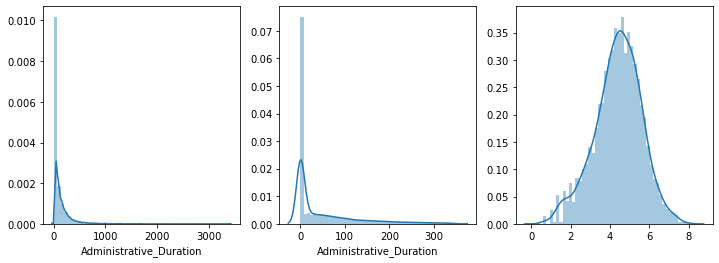

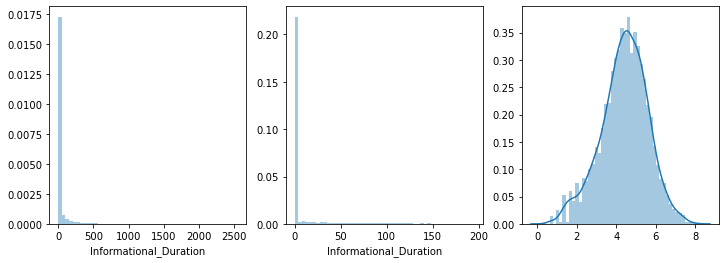

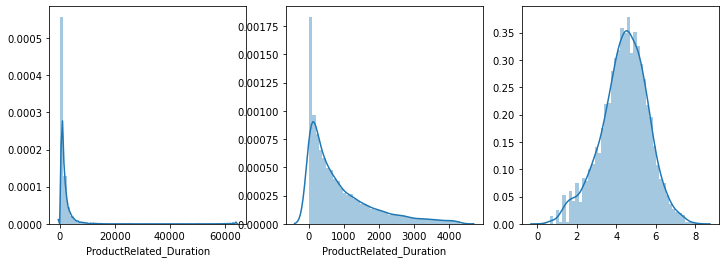

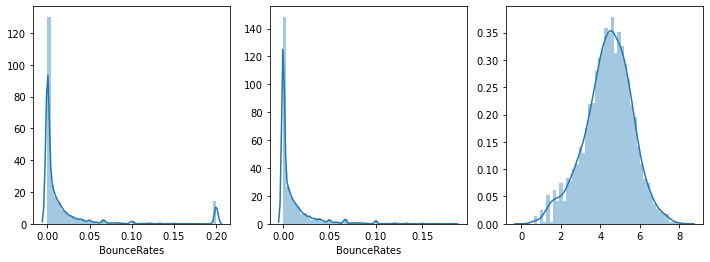

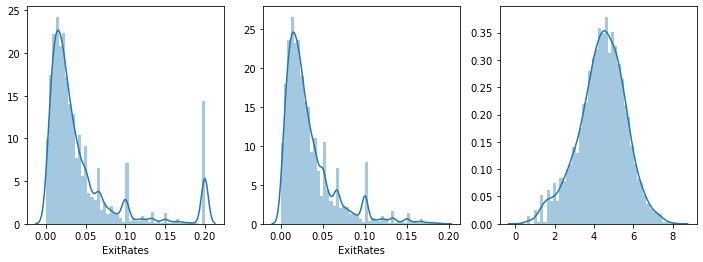

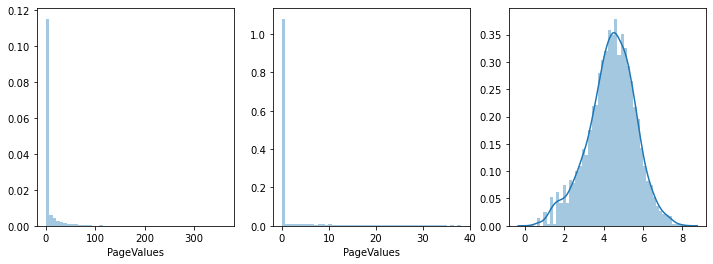

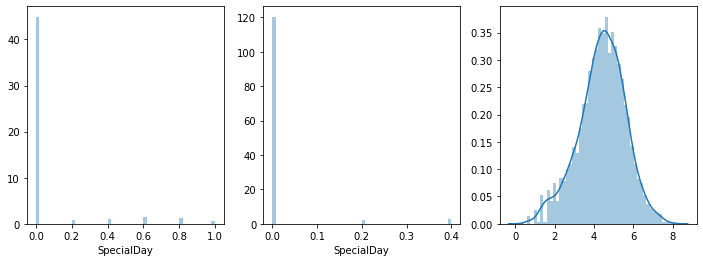

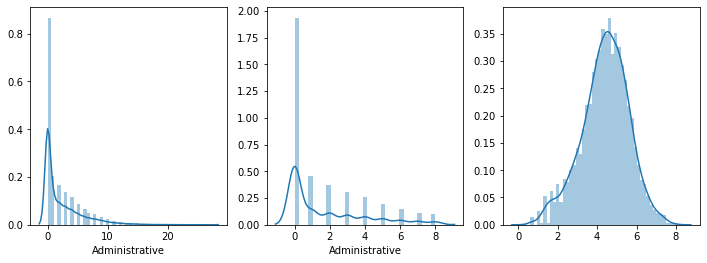

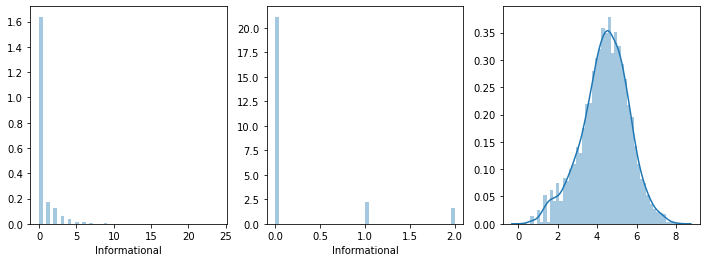

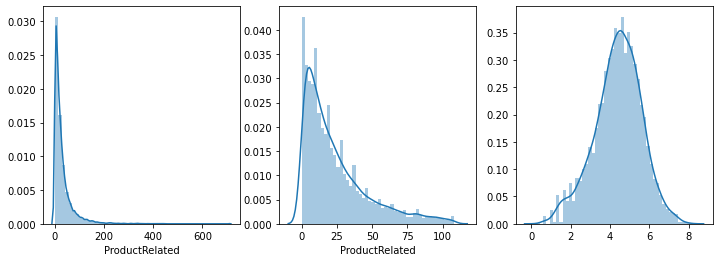

In [4]:
for name in num_cols:
    plt.figure(figsize=(12, 4))
    threshold = df[name].quantile(0.95)
    plt.subplot(1,3,1)
    sns.distplot(df[name])

    plt.subplot(1,3,2)
    sns.distplot(df[df[name] < threshold][name])
    
    plt.subplot(1,3,3)
    vvv = df[num_cols[0]].values
    sns.distplot(np.log(vvv[vvv > 0]))

In [5]:
df[cat_cols] = df[cat_cols].astype(str)

num_vals = df[num_cols].values
num_vals[num_vals > 0] = np.log(num_vals[num_vals > 0])
df[num_cols] = num_vals


In [6]:
cat_values = [df[c].unique().tolist() for c in cat_cols]

preprocessor = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(categories=cat_values), cat_cols)
)

X = df[num_cols + cat_cols]
y = df[tgt_cols].values.flatten()

cv = KFold(n_splits=5, shuffle=True)
models = [
    LogisticRegression(max_iter=10000, class_weight='balanced'),
    KNeighborsClassifier(n_neighbors=5),
    KNeighborsClassifier(n_neighbors=15),
    KNeighborsClassifier(n_neighbors=25),
    MLPClassifier(hidden_layer_sizes=(10,), early_stopping=True, max_iter=10000),
    MLPClassifier(hidden_layer_sizes=(50,), early_stopping=True, max_iter=10000),
    MLPClassifier(hidden_layer_sizes=(100,), early_stopping=True, max_iter=10000),
    RandomForestClassifier(n_estimators=12, class_weight='balanced'),
    RandomForestClassifier(n_estimators=25, class_weight='balanced'),
    RandomForestClassifier(n_estimators=50, class_weight='balanced'),
]

metrics = []
for model in models:
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    auc_vals = []
    for train_idx, test_idx in cv.split(X):
        clf.fit(X.iloc[train_idx], y[train_idx])
        y_pred = clf.predict_proba(X.iloc[test_idx])
        fpr, tpr, thresholds = roc_curve(y[test_idx], y_pred[:, 1])
        auc_vals += [auc(fpr, tpr)]
    metrics += [np.mean(auc_vals)]
    print('%.4f' % metrics[-1], model)

0.9135 LogisticRegression(class_weight='balanced', max_iter=10000)
0.8680 KNeighborsClassifier()
0.8971 KNeighborsClassifier(n_neighbors=15)
0.9056 KNeighborsClassifier(n_neighbors=25)
0.9159 MLPClassifier(early_stopping=True, hidden_layer_sizes=(10,), max_iter=10000)
0.9222 MLPClassifier(early_stopping=True, hidden_layer_sizes=(50,), max_iter=10000)
0.9235 MLPClassifier(early_stopping=True, max_iter=10000)
0.8921 RandomForestClassifier(class_weight='balanced', n_estimators=12)
0.9120 RandomForestClassifier(class_weight='balanced', n_estimators=25)
0.9173 RandomForestClassifier(class_weight='balanced', n_estimators=50)


In [7]:
#model = RandomForestClassifier(class_weight='balanced', n_estimators=150, max_depth=7)
model = MLPClassifier(early_stopping=True, hidden_layer_sizes=(10,), max_iter=10000)
clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

idx = np.random.permutation(X.shape[0])
score_names = ('accuracy', 'precision', 'recall', 'f1')
result = cross_validate(clf, X.iloc[idx], y[idx], scoring=score_names, return_train_score=True, cv=5)

print('---------------------- train ----------------------')
for name in score_names:
    vals = result[f'train_{name}']
    print('train %-10s %.2f' % (name, np.mean(vals)), '                ', result[f'train_{name}'])
    
print('\n---------------------- test ----------------------')
for name in score_names:
    vals = result[f'test_{name}']
    print('test %-10s %.2f' % (name, np.mean(vals)), '                ', result[f'test_{name}'])


---------------------- train ----------------------
train accuracy   0.90                  [0.8979116  0.90429846 0.89476886 0.90439984 0.89537713]
train precision  0.73                  [0.71001616 0.73153296 0.71516755 0.74434199 0.73934109]
train recall     0.56                  [0.57563851 0.60314342 0.53145478 0.5819135  0.5       ]
train f1         0.63                  [0.6358047  0.66116296 0.60977444 0.65318132 0.59655981]

---------------------- test ----------------------
test accuracy   0.90                  [0.8892944  0.8945661  0.90145985 0.89578264 0.89983779]
test precision  0.72                  [0.66463415 0.70648464 0.75090253 0.72563177 0.75280899]
test recall     0.54                  [0.57217848 0.54330709 0.54450262 0.52617801 0.52617801]
test f1         0.62                  [0.61495063 0.61424332 0.63125948 0.61001517 0.61941448]
